## Packages Required

In [77]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import sklearn
import matplotlib.pyplot as plt

# SVI Jump-Wings Parameterisation

### Parameters

In [375]:
class SVI():
    def __init__(self, a, b, rho, sig, m):
        self.volData = volData
        self.a = a
        self.m = m
        self.b = b
        self.rho = rho
        self.sig = sig

    def SVI_raw(self, volData, a, b, m, rho, sig):
        self.daysExp = volData[0,:]/365
        self.strike = volData[1,:]
        totalVol = a + b * (
            rho * (self.strike - m) + np.sqrt((self.strike - m) ** 2) + sig **2)
        impliedVol = totalVol / self.daysExp
        return impliedVol
    
    def SVI_JW(self, volData):
        self.daysExp = volData[0,:]/365
        self.strike = volData[1,:]
        # raw Parameters
        a = self.a
        b = self.b
        rho = self.rho
        m = self.m
        sig = self.sig
        t = self.daysExp
        
        # SVI Jump-Wings
        wt = (self.a + self.b * ( - self.rho * m + np.sqrt(self.m ** 2 + self.sig ** 2)))
        vt = wt / (t)
        phit = (1 / np.sqrt(wt)) * self.b / 2 * ( - self.m / np.sqrt(self.m ** 2 + self.sig ** 2) + self.rho)
        pt = 1 / np.sqrt(wt) * self.b * (1 - self.rho)
        ct = 1 / np.sqrt(wt) * self.b * ( 1+ self.rho)
        vTilde = (self.a + self.b * self.sig * np.sqrt(1 - self.rho ** 2)) / (t)
        
        # Parameterisation
        beta = self.rho - 2 * phit * np.sqrt(wt) / self.b
        alpha = np.sign(beta) * np.sqrt(1/(beta ** 2) - 1)
        
        bNew = np.sqrt(wt) / 2 * (ct + pt)
        rhoNew = 1 - pt * np.sqrt(wt)/b
        mNew = ((vt - vTilde) * t)/(b *(
            - rho + np.sign(alpha) * np.sqrt(1 + alpha ** 2) - alpha * np.sqrt(1 - rho ** 2)))
        aNew = vTilde * t - b * sig * np.sqrt(1 - rho)        
        if m == 0:
            sigNew = (vt * t - a)/b
        else:
            sigNew = alpha * m
            
        impliedVol = self.SVI_raw(a = aNew, b = bNew, m = mNew, rho = rhoNew, sig = sigNew)
        
        return impliedVol
        

        

In [521]:
def SVI_raw(volData, a, b, m, rho, sig):
        daysExp = volData[0,:]
        strike = volData[1,:]
        totalVol = a + b * (
            rho * (strike - m) + np.sqrt((strike - m) ** 2 + sig **2))
        impliedVol = np.sqrt(totalVol / daysExp)
        return impliedVol
    
def SVI_JW(volData, a, b, m, rho, sig):
        daysExp = volData[0,:]
        strike = volData[1,:]
        t = daysExp
        
        # SVI Jump-Wings
        wt = (a + b * ( - rho * m + np.sqrt(m ** 2 + sig ** 2)))
        vt = wt / (t)
        phit = (1 / np.sqrt(wt)) * b / 2 * ( - m / np.sqrt(m ** 2 + sig ** 2) + rho)
        pt = 1 / np.sqrt(wt) * b * (1 - rho)
        ct = 1 / np.sqrt(wt) * b * ( 1+ rho)
        vTilde = (a + b * sig * np.sqrt(1 - rho ** 2)) / (t)
        
        # Parameterisation
        beta = rho - 2 * phit * np.sqrt(wt) / b
        alpha = np.sign(beta) * np.sqrt(1/(beta ** 2) - 1)
        
        bNew = np.sqrt(wt) / 2 * (ct + pt)
        rhoNew = 1 - pt * np.sqrt(wt)/b
        mNew = ((vt - vTilde) * t)/(b *(
            - rho + np.sign(alpha) * np.sqrt(1 + alpha ** 2) - alpha * np.sqrt(1 - rho ** 2)))
        aNew = vTilde * t - b * sig * np.sqrt(1 - rho)        
        if m == 0:
            sigNew = (vt * t - a)/b
        else:
            sigNew = alpha * m
            
        impliedVol = SVI_raw(volData = volData, a = aNew, b = bNew, m = mNew, rho = rhoNew, sig = sigNew)
        
        return impliedVol

## Fitting the IV Curve

In [4]:
priceData = np.load('joinData.pkl', allow_pickle = True)

In [522]:
allData = priceData.loc['2015-01-02':'2015-02-01']
allData.strike = allData.strike/allData.SP500
numDates = allData.index.unique().size
allData.index.unique()

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/2397014149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allData.strike = allData.strike/allData.SP500


DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20',
               '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [523]:
SVIparameters = np.zeros((numDates, 5))
initVal = [0.4,0.1,0.1,-0.5,0.1]
bnds = ((None, None), (0.0001, None), (None, None), (-0.9999, 0.9999), (0.0001, None))

for i in range(numDates):
    dateData = allData.loc[allData.index.unique()[i]]
    dateData = dateData[dateData.daysExp.isin(dateData.daysExp.unique()[0:4])]

    yData = dateData.filter(['IV'])
    yData = np.array(yData).T[0]

    xData = dateData.filter(['daysExp', 'strike'])
    xData = np.array(xData).T
    
    def nonLinConstraintFun(x):
        return (x[0] + x[1] * x[4] * np.sqrt(1 - x[3] **2))

    nonLinearConstraint = opt.NonlinearConstraint(nonLinConstraintFun, 0, np.inf)
    
    cons = ({'type' : 'ineq', 'fun' : nonLinConstraint})
        
    ## Least Squares Minimisation
    funcToMin = lambda x: sum((SVI_raw(xData, x[0], x[1], x[2], x[3], x[4]) - yData)**2)
    fittedValues = opt.minimize(funcToMin, initVal, constraints = [nonLinearConstraint], bounds = bnds,
                                method = 'SLSQP', options={'maxiter':10000})
    SVIparameters[i,:] = fittedValues.x

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, cli

We fit the curve via Least Squares with linear and non-linear contraints on the parameters.


In [524]:
SVIparameters

array([[-7.23316992e+01,  4.55136188e+02,  2.84653007e-01,
        -9.02578870e-01,  3.71597012e-01],
       [-7.73849230e+01,  6.80773561e+02,  2.10495551e-01,
        -9.35539608e-01,  3.24009574e-01],
       [-9.42071805e+01,  2.17780691e+02,  2.66021233e-01,
        -7.61622861e-01,  6.71563116e-01],
       [-2.12428475e+01,  4.78249862e+01,  1.02410705e+00,
        -1.59597585e-01,  4.71123687e-01],
       [-1.27942676e+01,  3.88195714e+01,  1.01579106e+00,
        -1.92584672e-01,  3.57160852e-01],
       [-1.06384855e+01,  3.60629700e+01,  1.06935298e+00,
        -8.72446731e-02,  3.18556874e-01],
       [-3.41768665e+02,  1.77408246e+02,  1.17745295e+00,
         3.16214506e-02,  1.93219400e+00],
       [-3.29818921e+01,  5.90461544e+01,  1.01730171e+00,
        -1.43650520e-01,  5.79474520e-01],
       [-6.90313042e+01,  8.09846854e+01,  1.00862228e+00,
        -1.15123419e-01,  8.69807612e-01],
       [-3.78779799e+01,  6.14391998e+01,  1.07032448e+00,
        -7.71052211e-02

In [526]:
dateData = allData.loc[allData.index.unique()[0]]
dateData = dateData[dateData.daysExp.isin(dateData.daysExp.unique()[0:4])]

yData = dateData.filter(['IV'])
yData = np.array(yData).T[0]

xData = dateData.filter(['daysExp', 'strike'])
xData = np.array(xData).T

In [527]:
# Constraints
def nonLinConstraintFun(x):
    return (x[0] + x[1] * x[4] * np.sqrt(1 - x[3] **2))

nonLinearConstraint = opt.NonlinearConstraint(nonLinConstraintFun, 0, np.inf)
bnds = ((None, None), (0.0001, None), (None, None), (-0.999, 0.999), (0.0001, None))

#linConstraint = opt.LinearConstraint(np.eye(5),[-np.inf, 0, -np.inf, -0.9999, 0.00001],
                               #      [np.inf, np.inf, np.inf, 0.9999, np.inf])

## Initial Values
initVal = [0.4,0.5,0.5,0.5,0.5]
cons = ({'type' : 'ineq', 'fun' : nonLinConstraint})
        
## Least Squares Minimisation
funcToMin = lambda x: sum((SVI_raw(xData, x[0], x[1], x[2], x[3], x[4]) - yData)**2)
fittedValues = opt.minimize(funcToMin, initVal, constraints = [nonLinearConstraint], bounds = bnds,
                            method = 'SLSQP', options={'maxiter':10000})
fittedValues

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)


     fun: 1.6531703229279624
     jac: array([-3.09920311e-03, -3.77520919e-04, -2.45903730e-02, -4.15740579e-01,
       -3.06297168e-01])
 message: 'Optimization terminated successfully'
    nfev: 618
     nit: 95
    njev: 95
  status: 0
 success: True
       x: array([-7.14253663e+01,  5.99140674e+02,  2.38376938e-01, -9.30728684e-01,
        3.28118091e-01])

## Test Plot for the fitting
We will test using a slice of the surface

In [528]:
testSet = dateData[dateData['daysExp'] == dateData.daysExp.unique()[0]]


In [531]:
strikeAxis = np.linspace(0.3, 1.4, 1000).T
timeValue = np.ones(1000) * dateData.daysExp.unique()[0]
xDataTest = np.stack([timeValue, strikeAxis])
[a, b, m, rho, sig] = fittedValues.x
fittedCurve = SVI_raw(xDataTest, a, b, m, rho, sig) 

Text(0, 0.5, 'IV')

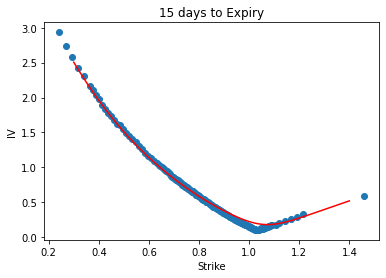

In [532]:
plt.scatter(testSet.strike, testSet.IV)
plt.plot(strikeAxis, fittedCurve, 'r-')
plt.title('15 days to Expiry')
plt.xlabel('Strike')
plt.ylabel('IV')
